# Import Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Data Loading

In [2]:
base_dir = 'input'
class_labels = os.listdir(base_dir)
class_labels.sort()

print(class_labels)

['Arson', 'Burglary', 'Explosion', 'Fighting', 'Normal']


In [3]:
chart_data = []

for target in class_labels:
    path = os.path.join(base_dir,target)
    size = len(os.listdir(path))
    chart_data.append(size)
    print(f'The target {target:<10} has ({size}) samples in the dataset')

The target Arson      has (2216) samples in the dataset
The target Burglary   has (1542) samples in the dataset
The target Explosion  has (2075) samples in the dataset
The target Fighting   has (1679) samples in the dataset
The target Normal     has (1852) samples in the dataset


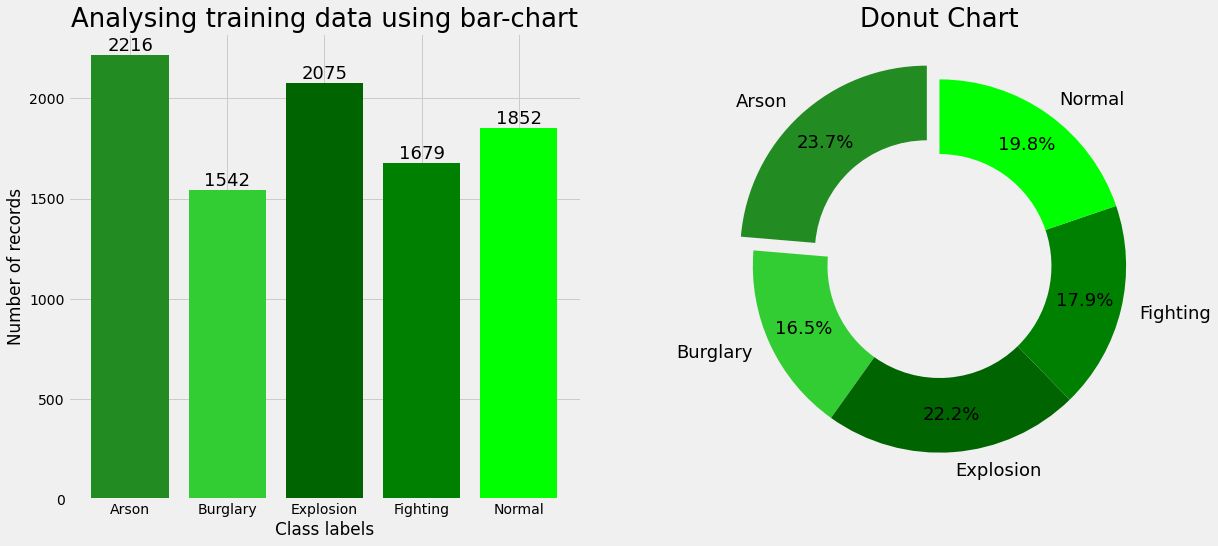

In [5]:
with plt.style.context(style="fivethirtyeight"):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
    plt.rcParams["font.size"] = 18

    ax1.bar(x=class_labels,
            height=chart_data,
            color=["forestgreen", "limegreen", "darkgreen", "green", "lime"])

    for i, value in enumerate(chart_data):
        ax1.text(i, value + 1, str(value), ha='center', va='bottom')

    ax1.set_title("Analysing training data using bar-chart")
    ax1.set_xlabel("Class labels")
    ax1.set_ylabel("Number of records")
    sizes = np.array(chart_data)
    explode = [0.1] + [0] * (len(sizes) - 1)

    ax2.pie(sizes, labels=class_labels, autopct='%1.1f%%', startangle=90, colors=["forestgreen", "limegreen", "darkgreen", "green", "lime"],
            wedgeprops=dict(width=0.4), explode=explode, pctdistance=0.80)

    ax2.set_title("Donut Chart")

    plt.show()

In [6]:
data = []
labels = []

for idx, target in enumerate(class_labels):
    path = os.path.join(base_dir, target)
    image_names = os.listdir(path)
    for image_name in tqdm(image_names, desc=f'Loading {target} images', total=len(image_names)):
        image_path = os.path.join(path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))
        image = np.array(image)
        image = image/255.0
        data.append(image)
        labels.append(idx)

Loading Normal images: 100%|███████████████████████████████████████████████████████| 1852/1852 [01:38<00:00, 18.76it/s]


In [7]:
data = np.array(data)
labels = np.array(labels)

print(data.shape, labels.shape)

(9364, 128, 128, 3) (9364,)


In [8]:
def show_images(X,y,class_names):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        idx = random.randint(0, X.shape[0]-1)
        plt.imshow(X[idx])
        plt.axis("off")
        plt.title("Class:{}".format(class_names[y[idx]]))
    plt.tight_layout()
    plt.show()

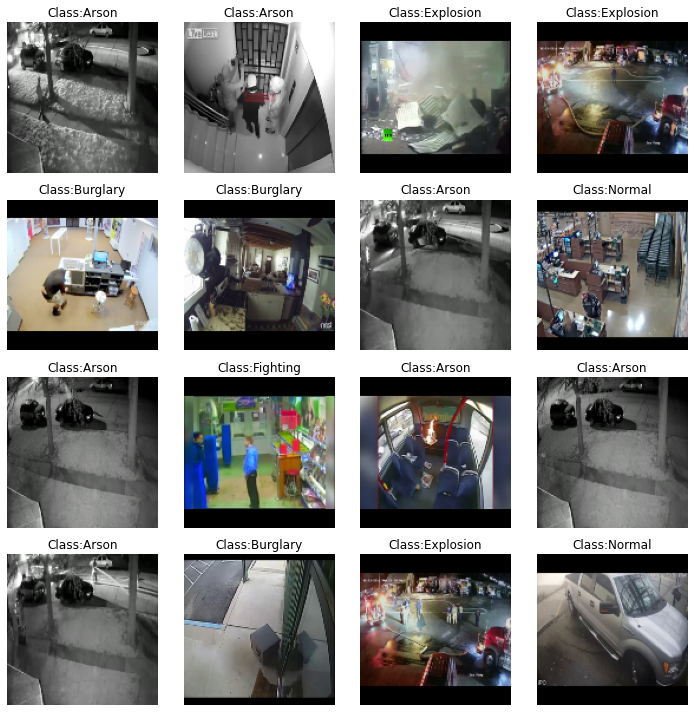

In [9]:
show_images(data,labels,class_labels)

In [13]:
labels = to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed_value)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7491, 128, 128, 3) (1873, 128, 128, 3) (7491, 5) (1873, 5)


---

# Algorithm: DenseNet201

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [15]:
densenet_model = tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(128,128,3),
    pooling="max",
    classes=1000
)

densenet_model.trainable = False

74836368/74836368 [==============================] - 4s 0us/step


In [16]:
inputs = densenet_model.input
dropout = tf.keras.layers.Dropout(rate=0.3)(densenet_model.output)
fc1 = tf.keras.layers.Dense(512, activation='relu')(dropout)
outputs = tf.keras.layers.Dense(len(class_labels), activation='softmax')(fc1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 134, 134, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 64, 64, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1/conv[0][0]']      

In [18]:
EPOCHS = 10

history = model.fit(
    x=data,
    y=labels,
    batch_size=32,
    epochs=EPOCHS,
    validation_data=(X_train, y_train),
    callbacks=[ReduceLROnPlateau(monitor='val_accuracy', patience=2, min_lr=0)]
)

Epoch 1/10
293/293 [==============================] - 58s 139ms/step - loss: 0.6710 - accuracy: 0.7771 - val_loss: 0.1660 - val_accuracy: 0.9505 - lr: 1.0000e-04
Epoch 2/10
293/293 [==============================] - 28s 96ms/step - loss: 0.2370 - accuracy: 0.9186 - val_loss: 0.0845 - val_accuracy: 0.9730 - lr: 1.0000e-04
Epoch 3/10
293/293 [==============================] - 29s 98ms/step - loss: 0.1543 - accuracy: 0.9517 - val_loss: 0.0655 - val_accuracy: 0.9809 - lr: 1.0000e-04
Epoch 4/10
293/293 [==============================] - 28s 97ms/step - loss: 0.1270 - accuracy: 0.9584 - val_loss: 0.0364 - val_accuracy: 0.9919 - lr: 1.0000e-04
Epoch 5/10
293/293 [==============================] - 28s 97ms/step - loss: 0.0983 - accuracy: 0.9679 - val_loss: 0.0261 - val_accuracy: 0.9940 - lr: 1.0000e-04
Epoch 6/10
293/293 [==============================] - 28s 97ms/step - loss: 0.0799 - accuracy: 0.9735 - val_loss: 0.0259 - val_accuracy: 0.9929 - lr: 1.0000e-04
Epoch 7/10
293/293 [=============

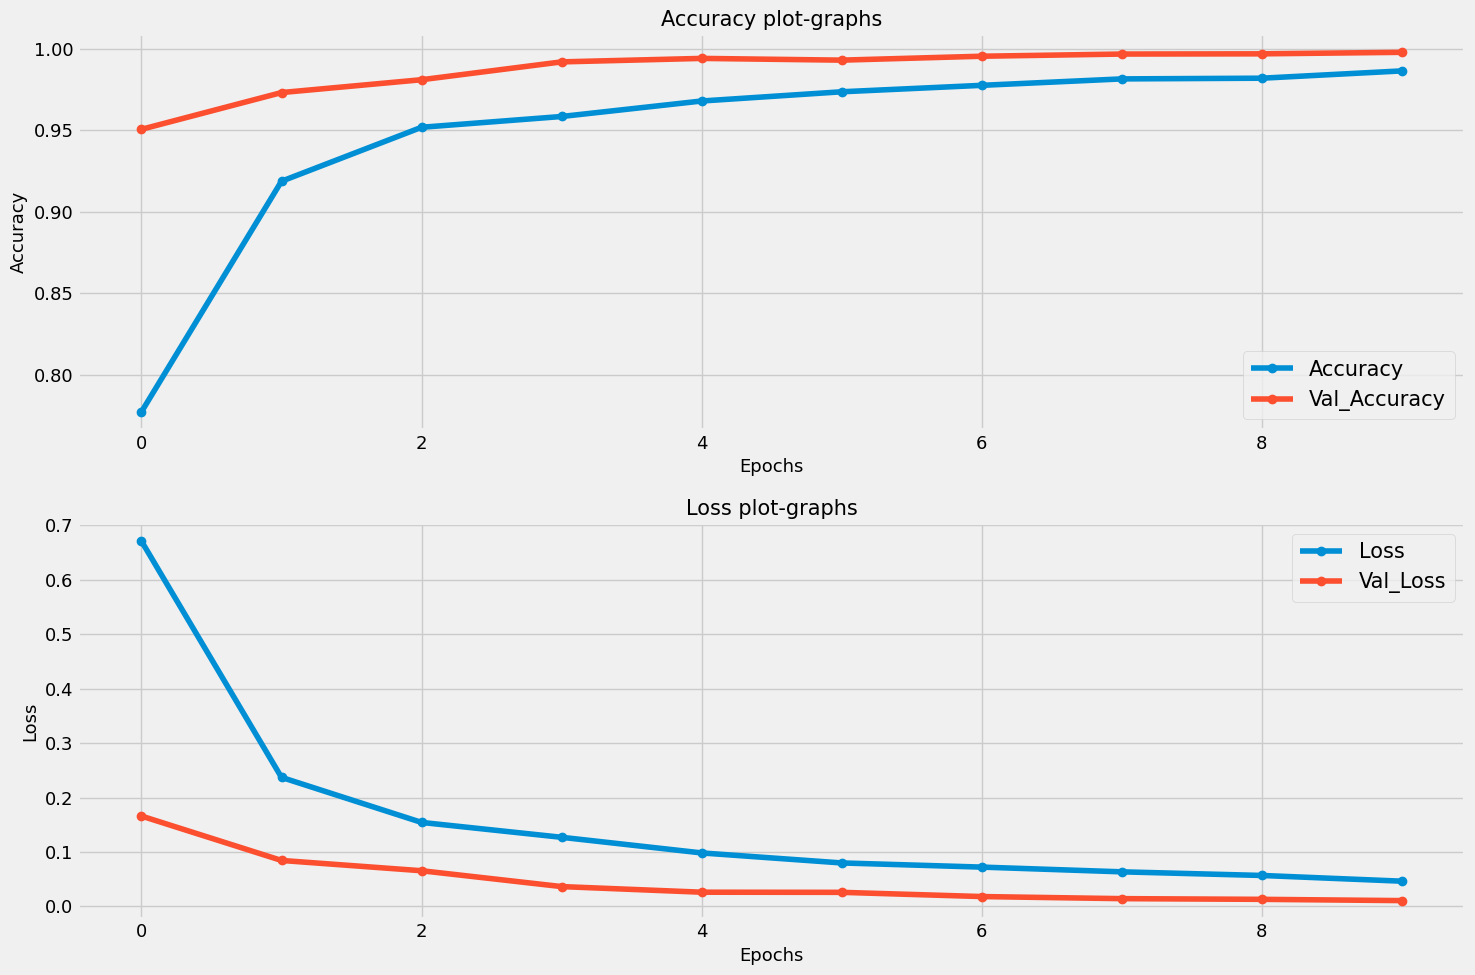

In [19]:
with plt.style.context(style="fivethirtyeight"):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
    plt.rcParams["font.size"] = 15

    axes[0].plot(history.history['accuracy'], label='Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Val_Accuracy', marker='o')
    axes[0].set_title(label='Accuracy plot-graphs', fontsize=15)
    axes[0].set_xlabel(xlabel='Epochs', fontsize=13)
    axes[0].set_ylabel(ylabel='Accuracy', fontsize=13)
    axes[0].tick_params(axis='both', which='major', labelsize=13)
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Val_Loss', marker='o')
    axes[1].set_title(label='Loss plot-graphs', fontsize=15)
    axes[1].set_xlabel(xlabel='Epochs', fontsize=13)
    axes[1].set_ylabel(ylabel='Loss', fontsize=13)
    axes[1].tick_params(axis='both', which='major', labelsize=13)
    axes[1].legend()

    fig.tight_layout()
    plt.show()

In [20]:
model_prediction = model.predict(X_test, batch_size=32, verbose=1)
print(model_prediction)

59/59 [==============================] - 10s 115ms/step
[[1.0000000e+00 5.2783298e-09 9.4883745e-10 1.1856250e-09 1.4929503e-09]
 [1.6046233e-05 3.6530148e-06 9.9996066e-01 3.7637010e-06 1.5839818e-05]
 [2.1306362e-06 1.5367910e-06 1.4197975e-07 3.7638029e-07 9.9999583e-01]
 ...
 [3.2126713e-06 5.3212898e-06 1.2086530e-06 4.3732562e-06 9.9998593e-01]
 [2.3152517e-05 4.0471274e-05 3.6812911e-05 9.9982411e-01 7.5412892e-05]
 [1.0722441e-03 4.0587893e-04 6.2320891e-05 9.9843937e-01 2.0146661e-05]]


In [21]:
pred = np.argmax(model_prediction, axis=1)
print(pred.tolist())

[0, 2, 4, 4, 4, 0, 0, 3, 4, 0, 2, 3, 1, 3, 3, 1, 1, 2, 1, 0, 2, 3, 4, 0, 0, 0, 0, 0, 3, 3, 0, 1, 3, 2, 3, 3, 1, 3, 4, 1, 4, 0, 0, 2, 0, 4, 0, 3, 2, 3, 0, 3, 1, 0, 3, 0, 1, 1, 2, 3, 3, 0, 0, 0, 4, 2, 1, 0, 2, 4, 2, 1, 3, 0, 3, 2, 4, 2, 1, 3, 1, 0, 4, 3, 2, 4, 0, 2, 1, 4, 0, 2, 1, 2, 0, 3, 3, 3, 2, 4, 4, 2, 4, 2, 0, 4, 1, 4, 4, 0, 4, 1, 2, 0, 0, 0, 2, 1, 1, 2, 2, 4, 0, 4, 3, 1, 3, 3, 1, 1, 1, 0, 0, 2, 2, 3, 0, 0, 2, 4, 4, 2, 0, 0, 1, 1, 4, 0, 0, 3, 0, 0, 0, 2, 2, 2, 0, 0, 0, 3, 2, 3, 2, 1, 1, 0, 2, 4, 4, 3, 1, 3, 1, 3, 3, 2, 3, 0, 2, 2, 4, 2, 2, 1, 4, 4, 2, 4, 0, 1, 3, 3, 2, 0, 0, 4, 0, 0, 4, 2, 0, 4, 4, 1, 0, 0, 1, 1, 1, 1, 0, 4, 4, 3, 0, 1, 1, 3, 2, 0, 1, 2, 4, 4, 4, 2, 3, 0, 3, 1, 2, 1, 1, 3, 3, 0, 2, 2, 0, 3, 4, 4, 3, 4, 1, 4, 0, 0, 3, 2, 0, 4, 0, 2, 4, 0, 0, 2, 1, 4, 2, 4, 3, 0, 3, 3, 2, 0, 0, 2, 4, 4, 1, 1, 0, 1, 2, 1, 1, 1, 4, 0, 4, 0, 3, 2, 4, 1, 0, 2, 2, 4, 0, 3, 3, 4, 4, 2, 0, 3, 3, 2, 2, 1, 3, 3, 4, 0, 1, 2, 3, 2, 0, 3, 0, 3, 1, 4, 2, 0, 3, 0, 3, 1, 2, 2, 1, 2, 4, 2, 2, 0, 0, 

In [22]:
actual = np.argmax(y_test, axis=1)
print(actual.tolist())

[0, 2, 4, 4, 4, 0, 0, 3, 4, 0, 2, 3, 1, 3, 3, 1, 1, 2, 1, 0, 2, 3, 4, 0, 0, 0, 0, 0, 3, 3, 0, 1, 3, 2, 3, 3, 1, 3, 4, 1, 4, 0, 0, 2, 0, 4, 0, 3, 2, 3, 0, 3, 1, 0, 3, 0, 1, 1, 2, 3, 3, 0, 0, 0, 4, 2, 1, 0, 2, 4, 2, 1, 3, 0, 3, 2, 4, 2, 1, 3, 1, 0, 4, 3, 2, 4, 0, 2, 1, 4, 0, 2, 1, 2, 0, 3, 3, 3, 2, 4, 4, 2, 4, 2, 0, 4, 1, 4, 4, 0, 4, 1, 2, 0, 0, 0, 2, 1, 1, 2, 2, 4, 0, 4, 3, 1, 3, 3, 1, 1, 1, 0, 0, 2, 2, 3, 0, 0, 2, 4, 4, 2, 0, 0, 1, 1, 4, 0, 0, 3, 0, 0, 0, 2, 2, 2, 0, 0, 0, 3, 2, 3, 2, 1, 1, 0, 2, 4, 4, 3, 1, 3, 1, 3, 3, 2, 3, 0, 2, 2, 4, 2, 2, 1, 4, 4, 2, 4, 0, 1, 3, 3, 2, 0, 0, 4, 0, 0, 4, 2, 0, 4, 4, 1, 0, 0, 1, 1, 1, 1, 0, 4, 4, 3, 0, 1, 1, 3, 2, 0, 1, 2, 4, 4, 4, 2, 3, 0, 3, 1, 2, 1, 1, 3, 3, 0, 2, 2, 0, 3, 4, 4, 3, 4, 1, 4, 0, 0, 3, 2, 0, 4, 0, 2, 4, 0, 0, 2, 1, 4, 2, 4, 3, 0, 3, 3, 2, 0, 0, 2, 4, 4, 1, 1, 0, 1, 2, 1, 1, 1, 4, 0, 4, 0, 3, 2, 4, 1, 0, 2, 2, 4, 0, 3, 3, 4, 4, 2, 0, 3, 3, 2, 2, 1, 3, 3, 4, 0, 1, 2, 3, 2, 0, 3, 0, 3, 1, 4, 2, 0, 3, 0, 3, 1, 2, 2, 1, 2, 4, 2, 2, 0, 0, 

### Result Analysis

In [23]:
model_accuracy = accuracy_score(y_true=actual, y_pred=pred)
print(f"Validation accuracy of DenseNet201 model is {model_accuracy*100.0:.2f}%")

Validation accuracy of DenseNet201 model is 99.89%


***Classification Report***

In [29]:
import pandas as pd
df = pd.DataFrame(data=classification_report(y_true=actual, y_pred=pred, target_names=class_labels, output_dict=True))
df = df.T
df.index.name = 'class'
df.iloc[:-2]

,precision,recall,f1-score,support
class,,,,
Arson,0.995516,1.000000,0.997753,444.000000
Burglary,1.000000,0.996587,0.998291,293.000000
Explosion,1.000000,0.997717,0.998857,438.000000
Fighting,1.000000,1.000000,1.000000,348.000000
Normal,1.000000,1.000000,1.000000,350.000000
accuracy,0.998932,0.998932,0.998932,0.998932


***Confusion Matrix***

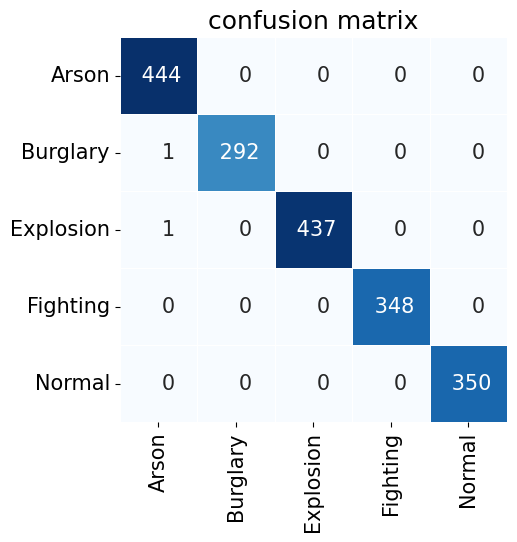

In [30]:
plt.figure(figsize=(5,5))
plt.rcParams['font.size']=15
sns.heatmap(
    data=confusion_matrix(y_true=actual, y_pred=pred),
    annot=True,
    fmt='4d',
    cbar=False,
    xticklabels=class_labels,
    yticklabels=class_labels,
    cmap=plt.cm.Blues,
    linewidths=0.5,
    linecolor='white'
)
plt.title(label='confusion matrix')
plt.show()

***model saving***

In [31]:
model.save("models/DenseNet201_model.h5")